# Creating a data driven network

This example shows how we create and add annotations to a data driven network.

In [32]:
%matplotlib inline
import sys
import os
import networkx as nx
from IPython.display import display, Image

In [29]:
from exp_data import exp_data
import magine.networks.utils as utils
from magine.networks.network_generator import build_network
from magine.networks.subgraphs import Subgraph
import magine.networks.exporters as exporters
import magine.networks.visualization as viz

Creating list of seed species and background species for network

In [ ]:
measured = exp_data.species.id_list
sig_measured = exp_data.species.sig.id_list
print(len(measured))
print(len(sig_measured))

Now we will create the network. We pass the seed and background list to the network as well as flags turning on all of the network databases. We also trim source/sink nodes (optional). This basically cleans up dangling nodes that are not in our seed or background lists.

In [4]:
save_name = 'bendamustine_network_w_attributes'

execute = False

if execute:
    network = build_network(
        seed_species=sig_measured,  # seed species
        all_measured_list=measured,  # all data measured
        use_biogrid=True,  # expand with biogrid
        use_hmdb=True,  # expand with hmdb
        use_reactome=True,  # expand with reactome
        use_signor=True,  # expand with signor
        trim_source_sink=True,  # remove all source and sink nodes not measured
        save_name='Networks/bendamustine_network'
    )
    # add data to networks
    network = utils.add_data_to_graph(network, exp_data)

    # write to GML for cytoscape or other program
    nx.write_gml(network, os.path.join('Networks', save_name+'.gml'))

    # write to gpickle for fast loading in python
    nx.write_gpickle(network, os.path.join('Networks', save_name+'.p'))
else:
    network = nx.read_gpickle(os.path.join('Networks', save_name+'.p'))

In [9]:
net_sub = Subgraph(network)

In [24]:
casp3_neighbors = net_sub.neighbors('CASP3', upstream=True, downstream=True)

In [25]:
viz.draw_cyjs(bax_n)

In [20]:
expand = net_sub.expand_neighbors(bax_n, nodes='CASP3', downstream=True, include_only=exp_data.species.sig.id_list)
viz.draw_cyjs(expand)

In [22]:
BAX_to_AKT = net_sub.paths_between_pair('BAX', 'AKT1')
viz.draw_cyjs(BAX_to_AKT)

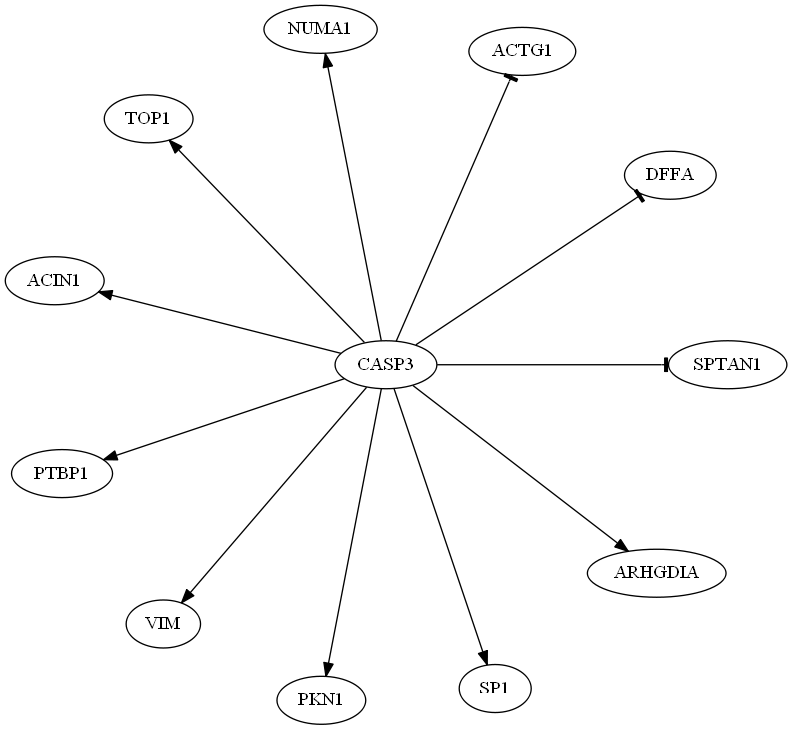

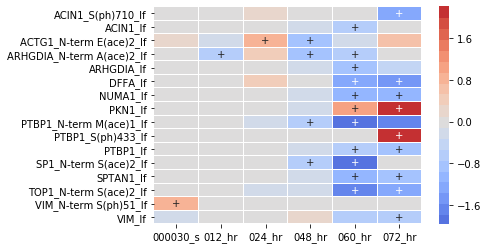

In [51]:
def show_neighbors(node, df, upstream=True, downstream=False, max_dist=1, 
                   include_only=None, figsize=None):
    

    neighbors = net_sub.expand_neighbors(
        network=None, 
        nodes=[node],
        upstream=upstream, 
        downstream=downstream, 
        max_dist=max_dist,
        include_only=include_only
    )
    df_copy = df.subset(neighbors.nodes).copy()
    
    # remove nodes not connected to casp3
    neighbors = utils.delete_disconnected_network(neighbors)
    
    # moves a time point if no signficant changes
    df_copy.require_n_sig(n_sig=1, inplace=True, index='sample_id', columns='label',)
    
    # removes measured species if no signficant changes
    df_copy.require_n_sig(n_sig=1, index='label', inplace=True)

    # export image
    s_name =  'node_{}.png'.format(node)
    exporters.export_to_dot(neighbors, s_name, image_format='png', engine='circo')
    
    # display image
    display(Image(s_name, width=400))
    
    # create heatmap of the neighnor nodes
    fig = df_copy.heatmap(
        rank_index=True, 
        index='label',
        linewidths=0.01,
        figsize=figsize
    );
    
    fig.savefig('{}_heatmap.png'.format(node), bbox_inches='tight', dpi=300)
show_neighbors('CASP3', exp_data.label_free, False, True, max_dist=1,
              include_only=exp_data.label_free.sig.require_n_sig(n_sig=2).id_list)

In [34]:
exp_data.label_free.heatmap(1)

,identifier,label,fold_change,significant,p_value,species_type,sample_id,source
478635,RHOXF2B,RHOXF2B_lf,1.51,True,0.0003,protein,036_hr,label_free


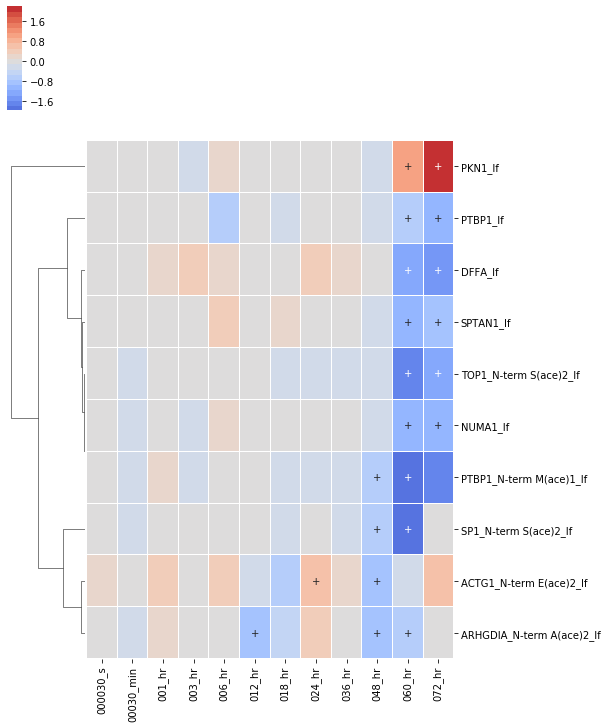

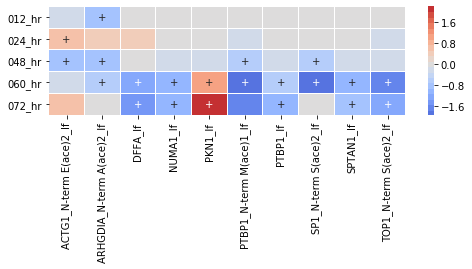

In [46]:
down_casp3 = net_sub.expand_neighbors(
    network=None, 
    nodes=['CASP3'], 
    upstream=False, downstream=True,
    max_dist=1,
    include_only=exp_data.label_free.sig.require_n_sig(index='label', n_sig=2).id_list
)
down_casp3 = utils.delete_disconnected_network(down_casp3)
exp_data.label_free.heatmap(
    down_casp3.nodes, 
    subset_index='identifier', index='label', 
    min_sig=2, linewidths=0.01,
    cluster_row=True
);

exp_data.label_free.require_n_sig(index='label', n_sig=2).heatmap(
    down_casp3.nodes, subset_index='identifier', 
    #index='label', 
    rank_index=True,
    figsize=(8, 2),
    index='sample_id', columns='label',
    min_sig=1, linewidths=0.01, cluster_row=False, cluster_col=False
);
